In [1]:

import pandas as pd
import numpy as np
from scipy.stats import skew
import warnings
import matplotlib
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet,Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
import seaborn as sns
# import xgboost as xgb


warnings.filterwarnings("ignore") 

%matplotlib inline

full_quarter_df=pd.read_csv("new_full_quarterData.csv",header=None)

#Lets read the data
train =full_quarter_df[20:38]
test =full_quarter_df.head(20)
# train = full_quarter_df.head(20)
# test =  full_quarter_df[20:38]
pd.options.display.max_columns = 50  # None -> No Restrictions
pd.options.display.max_rows = 200    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [2]:
#Data cleansing

all_data = pd.concat((train,
                      test))

#log transform the target:
# train[5] = np.log1p(train[5])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index  #Lets mark which features are very skewed.

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# all_data = pd.concat([all_data,pd.get_dummies(all_data['citypair'], prefix='segment')],axis=1)
# all_data = pd.concat([all_data,pd.get_dummies(all_data['aircraft'], prefix='plane')],axis=1)

# all_data.drop(['citypair'],axis=1, inplace=True)
# all_data.drop(['aircraft'],axis=1, inplace=True)

# bigFrame = pd.DataFrame({curr_year,curr_quarter})
# for name, group in all_data_1.groups :
#     print(name)
#     print(group)
#     print(str(year) +"-"+ str(quarter) +", " +citypair + " - "+ aircraft)
#     all_data_1.get_group(quarter, year, citypair, aircraft)
#     if curr_year==year and curr_quarter==quarter:
#         rowFrame=pd.DataFrame({citypair, aircraft,sum_departures_performed,sum_departures_scheduled,passengers,seats})
#         bigFrame=pd.concat(bigFrame,rowFrame)
#     else:
#         curr_year+=1
#         curr_quarter+=1
#         if curr_quarter ==5:
#             curr_quarter=1
#         newBigFrame = pd.DataFrame({curr_year,curr_quarter})
#         bigFrame=bigFrame.append(newBigFrame)
#         rowFrame=pd.DataFrame({citypair, aircraft,sum_departures_performed,sum_departures_scheduled,passengers,seats})
#         bigFrame=pd.concat(bigFrame,rowFrame)

# print(bigFrame)        
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(0)
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train[5]

In [3]:
def rmse_cv(model, dataset):
    rmse= np.sqrt(-cross_val_score(model, dataset, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def outputPredictionToCSV(predictionData, filename):
    arr = test.loc[:,0]
    arr2 = test.loc[:,1]
#     arr3 = np.expm1(predictionData)
    arr3=predictionData
    df = pd.DataFrame(data=arr, columns = ["Year"])
    df.applymap(int) 
    
    df1 = pd.DataFrame(data=arr2, columns = ["Quarter"])
    df1.applymap(int)
    
    df2 = pd.DataFrame(data=arr3, columns = ['predict.revenue'])
        
    df4 = pd.concat([df,df1,df2], axis=1)
    dff = pd.DataFrame(data=df4) 
    dff.to_csv(filename+".csv", index=False)
    

def printRMSE_MSE(modelName,model,trainData):
    print(modelName +" has RMSE of "+ str(rmse_cv(model,trainData).mean()))
    yHat= model.predict(trainData) 
    print(modelName + " has MSE on train data is: "+ str(mean_squared_error(y,yHat)))
    
def printActuals(predictionData):
    act_data = test
#     print(act_data)
    arr3 = predictionData
    percentErrors =[]
    for x in range(len(act_data.iloc[:,5])):
#     print(act_data.iloc[x,5])
        percentError= (100*(abs(float(act_data.iloc[x,5])-float(arr3[x]))/float(act_data.iloc[x,5])))
        print("Quarter : "+str(act_data.iloc[x,1])+" Year: "+str(act_data.iloc[x,0])+" : Actual: "+str(act_data.iloc[x,5])+" ,Prediction: "+str(arr3[x])+" ,Error: "+ str(percentError)+"%")
        percentErrors.append(percentError)
    print("Avg Percent Error is : "+str(sum(percentErrors) / len(percentErrors) ))

In [12]:
# ridge regression
modelForProblem1= Ridge(alpha=.1).fit(X_train, y)

printRMSE_MSE('ridge_regression_withGivenAlpha',modelForProblem1,X_train)

predictforModel1= modelForProblem1.predict(X_test)
outputPredictionToCSV(predictforModel1,'ridge_regression_withGivenAlpha_output')
printActuals(predictforModel1)
coeff_used = np.sum(modelForProblem1.coef_!=0)
print("Coeffients used: "+ str(coeff_used))
print(modelForProblem1.coef_)

ridge_regression_withGivenAlpha has RMSE of 419.42472780199085
ridge_regression_withGivenAlpha has MSE on train data is: 5.357720171833793e-20
Quarter : 1 Year: 2015 : Actual: 4414.0 ,Prediction: 3897.307776354399 ,Error: 11.705759484494816%
Quarter : 2 Year: 2015 : Actual: 5111.0 ,Prediction: 3974.2866754024626 ,Error: 22.240526797056102%
Quarter : 3 Year: 2015 : Actual: 5318.0 ,Prediction: 4583.23676353344 ,Error: 13.816533216746137%
Quarter : 4 Year: 2015 : Actual: 4977.0 ,Prediction: 4205.521304030159 ,Error: 15.500877958003642%
Quarter : 1 Year: 2016 : Actual: 4826.0 ,Prediction: 3930.5625600302506 ,Error: 18.554443430786353%
Quarter : 2 Year: 2016 : Actual: 5384.0 ,Prediction: 4308.285855095315 ,Error: 19.979831814722974%
Quarter : 3 Year: 2016 : Actual: 5139.0 ,Prediction: 4501.792896520292 ,Error: 12.399437701492667%
Quarter : 4 Year: 2016 : Actual: 4940.0 ,Prediction: 4376.740056110159 ,Error: 11.402023155664805%
Quarter : 1 Year: 2017 : Actual: 4854.0 ,Prediction: 4388.952602

In [5]:
# Find the best Alpha for a ridge regression and a lasso regression model.

alphas = [0.000005, 0.00005, 0.00001, 0.0005, 0.0001, 0.005, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 7, 8, 9,9.5, 10, 10.5, 11, 15, 30, 50, 75, 100]

cv_ridge = [rmse_cv(Ridge(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
print("The best ridge regression : "+str(cv_ridge.min()) +" with Alpha as " + str(cv_ridge.idxmin()))
print("The top five are:\n"+ str(cv_ridge.sort_values().head(5)))



cv_lasso = [rmse_cv(Lasso(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
print("\n\nThe best lasso regression : " +str(cv_lasso.min()) +" with Alpha as " + str(cv_lasso.idxmin()))
print("The top five are:\n"+ str(cv_lasso.sort_values().head(5)))

bestRidgeRegressionAlphaValue = cv_ridge.idxmin()
bestLassoRegressionAlphaValue = cv_lasso.idxmin()

The best ridge regression : 419.42472773794924 with Alpha as 100.0
The top five are:
100.0    419.425
75.0     419.425
50.0     419.425
30.0     419.425
15.0     419.425
dtype: float64


The best lasso regression : 313.799397267666 with Alpha as 0.5
The top five are:
0.5     313.799
0.3     315.219
3.0     330.837
30.0    335.136
15.0    344.732
dtype: float64


In [13]:
# ridge regression with best alpha
modelForProblem2= Ridge(alpha = bestRidgeRegressionAlphaValue).fit(X_train, y)

printRMSE_MSE('ridge_regression_withBestAlpha',modelForProblem2,X_train)

predictforModel2= modelForProblem2.predict(X_test)
outputPredictionToCSV(predictforModel2,'ridge_regression_WithBestAlpha_output')
printActuals(predictforModel2)
coeff_used = np.sum(modelForProblem2.coef_!=0)
print("Coeffients used: "+ str(coeff_used))
print(modelForProblem2.coef_)

ridge_regression_withBestAlpha has RMSE of 419.42472773794924
ridge_regression_withBestAlpha has MSE on train data is: 5.397096360967072e-14
Quarter : 1 Year: 2015 : Actual: 4414.0 ,Prediction: 3897.30777630587 ,Error: 11.705759485594246%
Quarter : 2 Year: 2015 : Actual: 5111.0 ,Prediction: 3974.2866755850782 ,Error: 22.24052679348311%
Quarter : 3 Year: 2015 : Actual: 5318.0 ,Prediction: 4583.236763487705 ,Error: 13.816533217606155%
Quarter : 4 Year: 2015 : Actual: 4977.0 ,Prediction: 4205.5213040153085 ,Error: 15.50087795830202%
Quarter : 1 Year: 2016 : Actual: 4826.0 ,Prediction: 3930.5625602021364 ,Error: 18.55444342722469%
Quarter : 2 Year: 2016 : Actual: 5384.0 ,Prediction: 4308.285855085796 ,Error: 19.97983181489977%
Quarter : 3 Year: 2016 : Actual: 5139.0 ,Prediction: 4501.792896618883 ,Error: 12.39943769957418%
Quarter : 4 Year: 2016 : Actual: 4940.0 ,Prediction: 4376.740056143699 ,Error: 11.402023154985852%
Quarter : 1 Year: 2017 : Actual: 4854.0 ,Prediction: 4388.95260299775 

In [15]:
# Lasso with best alpha
modelForProblem2b= Lasso(alpha = bestLassoRegressionAlphaValue).fit(X_train, y)

printRMSE_MSE('lasso_regression_withBestAlpha',modelForProblem2b,X_train)

predictforModel2b= modelForProblem2b.predict(X_test)
outputPredictionToCSV(predictforModel2b,'lasso_regression_WithBestAlpha_output')
printActuals(predictforModel2b)
coeff_used = np.sum(modelForProblem2b.coef_!=0)
print("Coeffients used: "+ str(coeff_used))
print(modelForProblem2b.coef_)

lasso_regression_withBestAlpha has RMSE of 313.799397267666
lasso_regression_withBestAlpha has MSE on train data is: 1.0221457236950073e-07
Quarter : 1 Year: 2015 : Actual: 4414.0 ,Prediction: 3603.530294356955 ,Error: 18.361343580494903%
Quarter : 2 Year: 2015 : Actual: 5111.0 ,Prediction: 4154.802001014614 ,Error: 18.70862842859296%
Quarter : 3 Year: 2015 : Actual: 5318.0 ,Prediction: 3513.5497715125675 ,Error: 33.930993390136%
Quarter : 4 Year: 2015 : Actual: 4977.0 ,Prediction: 3472.028364130296 ,Error: 30.23852995518795%
Quarter : 1 Year: 2016 : Actual: 4826.0 ,Prediction: 3158.612013175938 ,Error: 34.55010333245052%
Quarter : 2 Year: 2016 : Actual: 5384.0 ,Prediction: 3635.842688389559 ,Error: 32.46948944298739%
Quarter : 3 Year: 2016 : Actual: 5139.0 ,Prediction: 4340.281749481423 ,Error: 15.542289365996837%
Quarter : 4 Year: 2016 : Actual: 4940.0 ,Prediction: 3963.4128078853537 ,Error: 19.768971500296484%
Quarter : 1 Year: 2017 : Actual: 4854.0 ,Prediction: 3589.752680635196 ,E

       Alpha  None Zero Coefs
0  5.000e-06             2424
1  5.000e-05             2126
2  1.000e-05             2330
3  5.000e-04             1852
4  1.000e-04             2018
5  5.000e-03              951
6  5.000e-02              761
7  1.000e-01              721
8  3.000e-01              632
9  5.000e-01              600


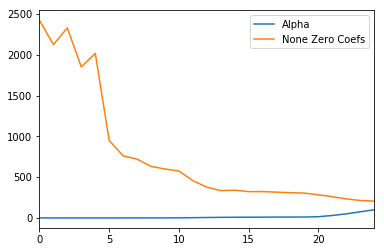

In [8]:
# l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary the regularization hyperparameter alpha.

# coefDF=[]
# alphaDF=[]

# for x in alphas:
#     temp_lasso= Lasso(alpha = x).fit(X_train, y)
#     coef = pd.Series(temp_lasso.coef_, index = X_train.columns)
#     coefDF.append(sum(coef != 0))
#     alphaDF.append(x)

# dfAlpha =pd.DataFrame(data=alphaDF, columns = ['Alpha'])
# dfCoef =pd.DataFrame(data=coefDF, columns = ['None Zero Coefs'])

# dff2= pd.concat([dfAlpha,dfCoef], axis=1)

# print(dff2.head(10))

# plotThis = pd.DataFrame(data=dff2)
# plotThis.plot()

In [9]:
# ridgeModel= pd.DataFrame(data= modelForProblem2.predict(X_train), columns=["RidgeRevPrice"])
# lassoModel= pd.DataFrame(data= modelForProblem2b.predict(X_train), columns=["LassoRevPrice"])

# ridgeModelTest= pd.DataFrame(data= modelForProblem2.predict(X_test), columns=["RidgeRevPrice"])
# lassoModelTest= pd.DataFrame(data= modelForProblem2b.predict(X_test), columns=["LassoRevPrice"])

# new_X_train=pd.concat([X_train,ridgeModel,lassoModel], axis=1)
# new_X_test=pd.concat([X_test,ridgeModelTest,lassoModelTest], axis=1)

# # print(new_X_train)


# alphas = [0.000005, 0.00005, 0.00001, 0.0005, 0.0001, 0.005, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 7, 8, 9,9.5, 10, 10.5, 11, 15, 30, 50, 75, 100]

# cv_ridge = [rmse_cv(Ridge(alpha = alpha),new_X_train).mean() 
#             for alpha in alphas]

# cv_ridge = pd.Series(cv_ridge, index = alphas)
# modelForProblem6= Ridge(alpha=cv_ridge.idxmin()).fit(new_X_train, y) 

# printRMSE_MSE('ridge_regression_stacking_output',modelForProblem6,new_X_train)

# predictforModel6 = modelForProblem6.predict(new_X_test)

# outputPredictionToCSV(predictforModel6,'ridge_regression_stacking_output')
# printActuals(predictforModel6)

       0  1        2      3          4       5      7      8        9  \
0   2010  1   78.807  2.591  2.576e+06  2630.0   80.0   86.0  10106.0   
1   2010  2   77.816  2.628  2.806e+06  3168.0  308.0  311.0  31478.0   
2   2010  3   76.062  2.555  2.837e+06  3192.0  361.0  365.0  38396.0   
3   2010  4   85.160  2.668  2.898e+06  3114.0  133.0  135.0  16719.0   
4   2011  1   94.066  2.607  2.989e+06  3103.0  263.0  269.0  26399.0   
5   2011  2  102.022  2.549  3.401e+06  4136.0  367.0  376.0  38384.0   
6   2011  3   89.493  2.335  3.346e+06  4311.0  178.0  182.0  23035.0   
7   2011  4   94.015  2.245  3.267e+06  4108.0  457.0  458.0  46822.0   
8   2012  1  102.984  2.309  3.285e+06  3991.0   92.0   93.0  10235.0   
9   2012  2   93.289  2.263  4.156e+06  4616.0  245.0  246.0  28480.0   
10  2012  3   92.168  2.322  4.258e+06  4309.0  179.0  181.0  22100.0   
11  2012  4   88.010  2.348  4.081e+06  4172.0  126.0  131.0  15301.0   
12  2013  1   94.325  2.551  4.014e+06  4084.0   92

ridge_regression_stacking_output has RMSE of 419.41817632610866
ridge_regression_stacking_output has MSE on train data is: 5.396880092153669e-14


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Problem 7, I am going to try stacking the previous two with XGB Regression
# I am tried playing around with different HyperParameters for XGB
# My final solution was a serial stack with different varieties of the stack




# rmse_values=[]
# mse_values=[]

# max_depths_values=[]
# n_estimators_values=[]
# reg_alphas_values=[]
# reg_lambdas_values=[]
# learning_rates_values=[]
# colsample_bynodes_values=[]
# subsamples_values=[]

# max_depths = [2,3,4]
# n_estimators =[300, 400,500,600,700]
# reg_alphas = [0.005, 0.05,0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1, 3, 5, 7, 9, 10, 10.5, 11]
# reg_lambdas = [0.005, 0.05,0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1, 3, 5, 7, 9, 10, 10.5, 11]
# learning_rates =[0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1]
# colsample_bynodes = [0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1]
# subsamples= [0.1, 0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1]
# for max_depth in max_depths:
#     # print('max depth is '+str(max_depth))
#     for n_estimator in n_estimators:
#         # print('estimator is '+str(n_estimator))
#         for reg_alpha in reg_alphas:
#             # print('alpha is '+str(reg_alpha))
#             for lambda_ in reg_lambdas:
#                 # print('lambda is '+str(lambda_))
#                 for learning_rate in learning_rates:
#                     # print('learning rate is '+str(learning_rate))
#                     for colsample_bynode in colsample_bynodes:
#                         # print('colsample is '+str(colsample_bynode))
#                         for subsample in subsamples:
#                             # print('subsample is '+str(subsample))
#                             modelForProblem7 = xgb.XGBRegressor(verbosity=0, max_depth=max_depth, n_estimators=n_estimator,
#                                                                 reg_alpha=reg_alpha, learning_rate=learning_rate, reg_lambda=lambda_,
#                                                                 colsample_bynode=colsample_bynode, subsample=subsample).fit(new_X_train, y)
#                             rmse_values.append(rmse_cv(modelForProblem7,new_X_train).mean())
#                             yHat= modelForProblem7.predict(new_X_train)
#                             mse_values.append(mean_squared_error(y,yHat))
#                             max_depths_values.append(max_depth)
#                             n_estimators_values.append(n_estimator)
#                             reg_alphas_values.append(reg_alpha)
#                             reg_lambdas_values.append(lambda_)
#                             learning_rates_values.append(learning_rate)
#                             colsample_bynodes_values.append(colsample_bynode)
#                             subsamples_values.append(subsample)
#                             print('RMSE is: '+str(rmse_values[-1])+' MSE is '+str(mse_values[-1]))

# dfRMSE =pd.DataFrame(data=rmse_values, columns = ['RMSE'])
# dfMSE =pd.DataFrame(data=mse_values, columns = ['MSE'])
# dfMaxDepth =pd.DataFrame(data=max_depths_values, columns = ['Max Depth'])
# dfEstimator =pd.DataFrame(data=n_estimators_values, columns = ['NEstimators'])
# dfAlphas =pd.DataFrame(data=reg_alphas_values, columns = ['Alpha'])
# dfLambdas =pd.DataFrame(data=reg_lambdas_values, columns = ['Lambda'])
# dfLearningRate =pd.DataFrame(data=learning_rates_values, columns = ['Learning Rate'])
# dfColSample =pd.DataFrame(data=colsample_bynodes_values, columns = ['ColSample'])
# dfSubSample =pd.DataFrame(data=subsamples_values, columns = ['SubSample'])
# bigdf =pd.concat([dfRMSE,dfMSE,dfMaxDepth,dfEstimator,dfAlphas,dfLambdas,dfLearningRate,dfColSample,dfSubSample], axis=1)

# bigdf.to_csv("tuneXGB.csv", index=False)

In [ ]:

# modelForProblem7a= RidgeCV().fit(X_train, y)
# dataFromRidge_train= pd.DataFrame(data= modelForProblem7a.predict(X_train), columns=["RidgeSalePrice"])
# dataFromRidge_test= pd.DataFrame(data= modelForProblem7a.predict(X_test), columns=["RidgeSalePrice"])
# a_X_train=pd.concat([X_train,dataFromRidge_train], axis=1)
# a_X_test=pd.concat([X_test,dataFromRidge_test], axis=1)
# printActuals(modelForProblem7a)

# modelForProblem7b= LassoCV().fit(a_X_train, y)
# dataFromLasso_train= pd.DataFrame(data= modelForProblem7b.predict(a_X_train), columns=["LassoSalePrice"])
# dataFromLasso_test= pd.DataFrame(data= modelForProblem7b.predict(a_X_test), columns=["LassoSalePrice"])
# printActuals(modelForProblem7b)

# b_X_train=pd.concat([X_train,dataFromLasso_train], axis=1)
# b_X_test=pd.concat([X_test,dataFromLasso_test], axis=1)

# printRMSE_MSE('serialStack_output',modelForProblem7b,b_X_train)

# predictforModel7b= modelForProblem7b.predict(b_X_test)
# outputPredictionToCSV(predictforModel7b,'serialStack_output')

# c_X_train=pd.concat([X_train,dataFromRidge_train,dataFromLasso_train], axis=1)
# c_X_test=pd.concat([X_test,dataFromRidge_test,dataFromLasso_test], axis=1)
# #with A dataset

# modelForProblem7WithLowValues_a = xgb.XGBRegressor(verbosity=0, max_depth=2,
#                                                  n_estimators=400, reg_alpha=10,
#                                                  learning_rate=.05,colsample_bynode=0.7, 
#                                                  subsample=0.85, reg_lambda=0.85).fit(a_X_train, y)
# printRMSE_MSE('xgb_output_a',modelForProblem7WithLowValues_a,a_X_train)

# predictforModel7WithLowestValue_a = modelForProblem7WithLowValues_a.predict(a_X_test)

# outputPredictionToCSV(predictforModel7WithLowestValue_a,'xgb_output_a')
# printActuals(predictforModel7WithLowestValue_a)

# # with B dataset

# modelForProblem7WithLowValues_b = xgb.XGBRegressor(verbosity=0, max_depth=2,
#                                                  n_estimators=400, reg_alpha=10,
#                                                  learning_rate=.05,colsample_bynode=0.7, 
#                                                  subsample=0.85, reg_lambda=0.85 ).fit(b_X_train, y)

# printRMSE_MSE('xgb_output_b',modelForProblem7WithLowValues_b,b_X_train)

# predictforModel7WithLowestValue_b = modelForProblem7WithLowValues_b.predict(b_X_test)

# outputPredictionToCSV(predictforModel7WithLowestValue_b,'xgb_output_b')

# printActuals(predictforModel7WithLowestValue_b)


# #with AB combined

# modelForProblem7WithLowValues_c = xgb.XGBRegressor(verbosity=0).fit(c_X_train, y)

# printRMSE_MSE('xgb_output_c',modelForProblem7WithLowValues_c,c_X_train)

# predictforModel7WithLowestValue_c = modelForProblem7WithLowValues_c.predict(c_X_test)

# outputPredictionToCSV(predictforModel7WithLowestValue_c,'xgb_output_c')

# printActuals(predictforModel7WithLowestValue_c)

# xgb_train= pd.DataFrame(data= modelForProblem7WithLowValues_c.predict(c_X_train), columns=["XGBSalePrice"])
# xgb_test= pd.DataFrame(data= modelForProblem7WithLowValues_c.predict(c_X_test), columns=["XGBSalePrice"])


# d_X_train=pd.concat([X_train,xgb_train], axis=1)
# d_X_test=pd.concat([X_test,xgb_test], axis=1)

# modelForProblem7d= ElasticNetCV().fit(d_X_train, y)

# printRMSE_MSE('xgb_output_d',modelForProblem7d,d_X_train)

# predictforModel7WithLowestValue_d = modelForProblem7d.predict(d_X_test)

# outputPredictionToCSV(predictforModel7WithLowestValue_d,'final_output')

# printActuals(modelForProblem7d)

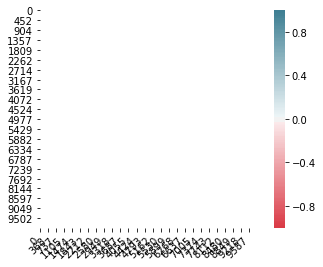

In [10]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 220, sep=5, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);